In [1]:
import cv2
import numpy as np

#since open CV 3.4.0, it can read darknet model by cv2.dnn.readNetFromDarknet
cv2.__version__

'3.4.10'

In [61]:
# wrapper function
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("./cfg_mask/yolov3-tiny.cfg", "./cfg_mask/yolov3-tiny_47000.weights")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("./cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]
scale = 0.05 # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image

def yolo_detect(img):
    # forward propogation
    #img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    #cv2.resize(frame, None, fx=0.4, fy=0.4, dst=img)
    #img = frame
    height, width, channels = img.shape 
    fontScale = min(height, width)/(25/scale)  
    # yolo v3
    # 320 x 320 (high speed, less accuracy)
    # 416 x 416 (moderate speed, moderate accuracy)
    # 608 x 608 (less speed, high accuracy)
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # redirect img to dst
    
    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.3:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y -5), font, fontScale, color, 1)
    return img

In [18]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *

base = BaseOverlay("base.bit")
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

hdmi_in.configure()
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

In [62]:
import time

numframes = 600
start = time.time()

for _ in range(numframes):
    f = hdmi_in.readframe()
    hdmi_out.writeframe(f)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  59.69945339959641


write once
Frames per second:  0.048151542977487076


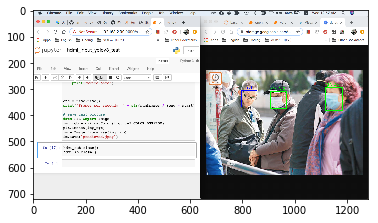

In [71]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

numframes = 1
start = time.time()

for _ in range(numframes):
    inframe = hdmi_in.readframe()
    #print(inframe.shape)
    img = yolo_detect(inframe)
    inframe.freebuffer()
    
    #outframe = hdmi_out.newframe()
    #cv2.cvtColor(img, cv2.COLOR_BGR2RGB, dst=outframe)
    #hdmi_out.writeframe(outframe)
    
    hdmi_out.writeframe(img)
    print("write once")
    

    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

# save last picture
from PIL import Image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
im = Image.fromarray(img_rgb)
im.save("predicted.jpeg")

In [17]:
hdmi_out.close()
hdmi_in.close()